In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow.keras.optimizers import SGD
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.convolutional import Conv2D,MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten, Activation, Dropout
from collections import Counter
from shutil import copy

# Verzeichnisse für Train und Test Datensatz

In [3]:
train_dataset_path = 'DataSet/Eggs/dataset_train'
test_dataset_path = 'DataSet/Eggs/dataset_test'

In [4]:
train_dataset=ImageDataGenerator(rescale=1.0/255.0)
test_dataset=ImageDataGenerator(rescale=1.0/255.0)

In [5]:
train_set=train_dataset.flow_from_directory(train_dataset_path, target_size=(64,64),
                                           batch_size=1, class_mode='categorical')
test_set=test_dataset.flow_from_directory(test_dataset_path, target_size=(64,64),
                                           batch_size=1, class_mode='categorical', shuffle = False)

batch_x, batch_y = train_set.next()
batch_x, batch_y = test_set.next()
print('Batch shape = %s, min = %.3f, max=%.3f' % (batch_x.shape, batch_x.min(), batch_x.max()))

Found 300 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Batch shape = (1, 64, 64, 3), min = 0.125, max=1.000


In [6]:
steps_per_epoch = len(train_set) 
validation_steps =len(test_set)
print('Training samples :', steps_per_epoch)
print('Test samples :', validation_steps)

Training samples : 300
Test samples : 150


[[1. 0. 0.]]


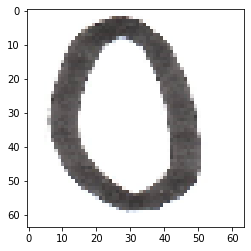

[[0. 1. 0.]]


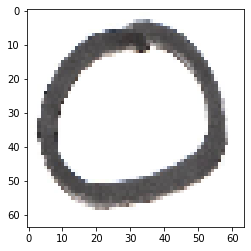

[[1. 0. 0.]]


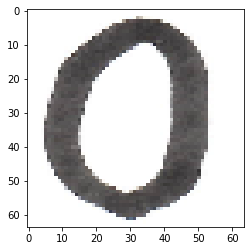

[[0. 0. 1.]]


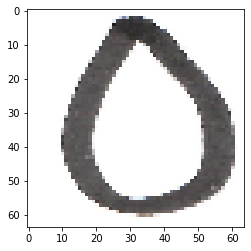

[[0. 1. 0.]]


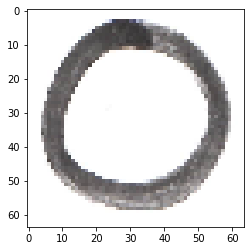

[[0. 1. 0.]]


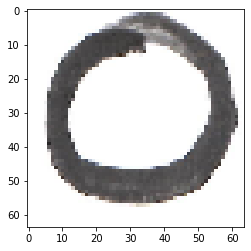

[[1. 0. 0.]]


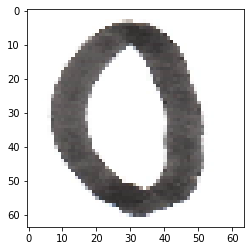

[[0. 0. 1.]]


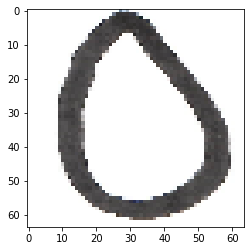

[[0. 0. 1.]]


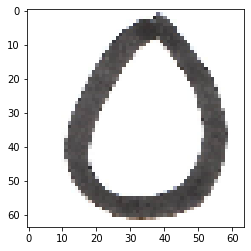

[[0. 0. 1.]]


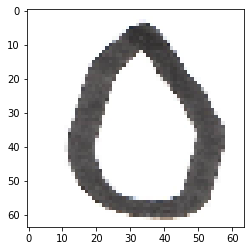

[[0. 1. 0.]]


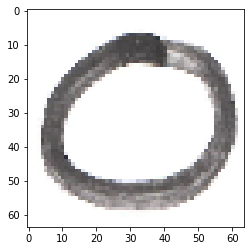

[[0. 0. 1.]]


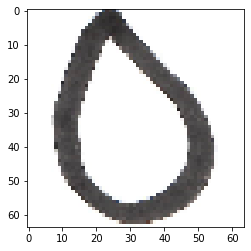

[[0. 1. 0.]]


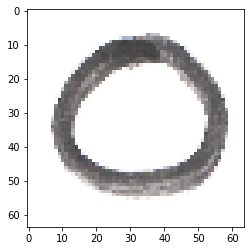

[[1. 0. 0.]]


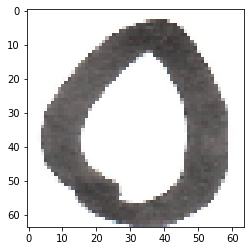

[[0. 0. 1.]]


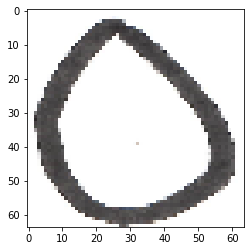

[[0. 0. 1.]]


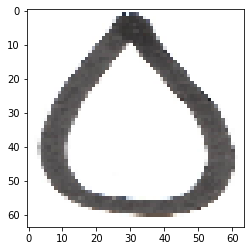

[[0. 0. 1.]]


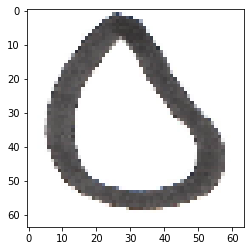

[[1. 0. 0.]]


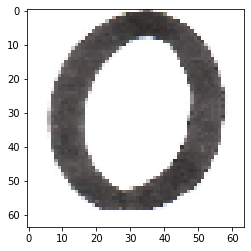

[[0. 1. 0.]]


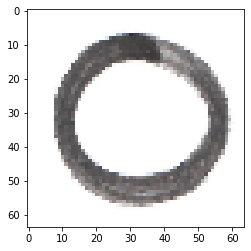

[[0. 0. 1.]]


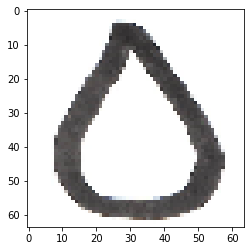

[[0. 1. 0.]]


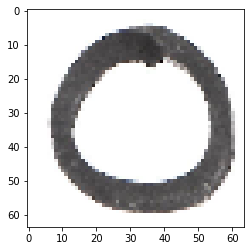

[[0. 1. 0.]]


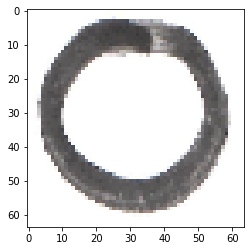

[[0. 0. 1.]]


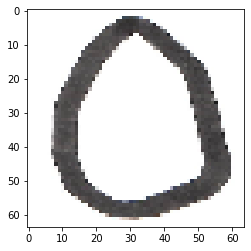

[[0. 1. 0.]]


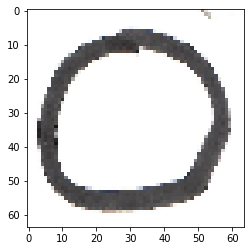

[[0. 0. 1.]]


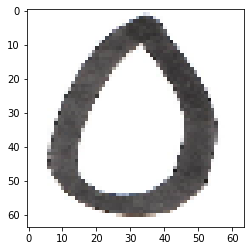

[[0. 1. 0.]]


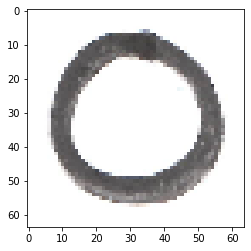

[[1. 0. 0.]]


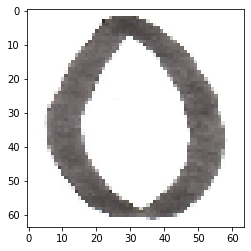

[[0. 1. 0.]]


KeyboardInterrupt: 

In [8]:
for i in range (0,300):
    train_batch_x, batch_y = train_set.next()
    image = train_batch_x[0]
    print(batch_y)
    plt.imshow(image)
    plt.show()
train_set.reset()
test_set.reset()

[[1. 0. 0.]]


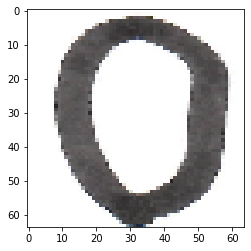

[[1. 0. 0.]]


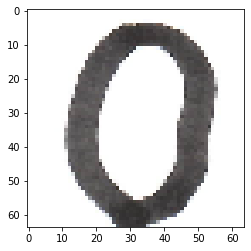

[[1. 0. 0.]]


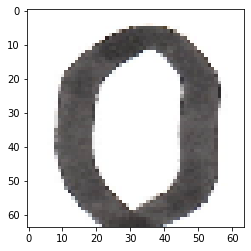

[[1. 0. 0.]]


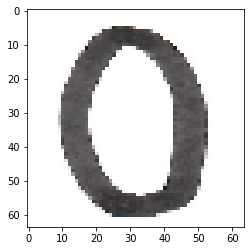

[[1. 0. 0.]]


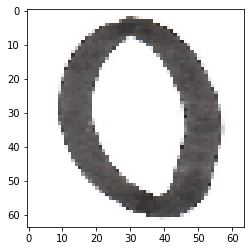

[[1. 0. 0.]]


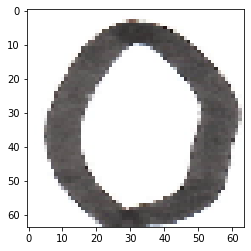

[[1. 0. 0.]]


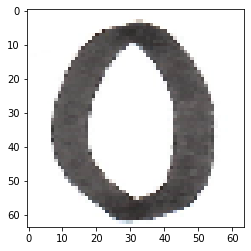

[[1. 0. 0.]]


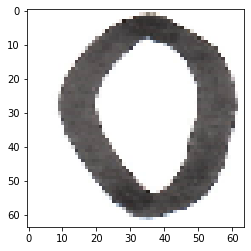

[[1. 0. 0.]]


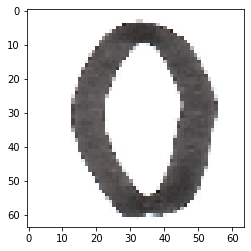

[[1. 0. 0.]]


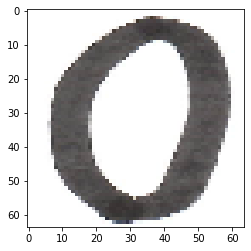

[[1. 0. 0.]]


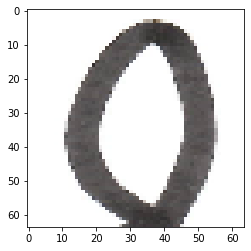

[[1. 0. 0.]]


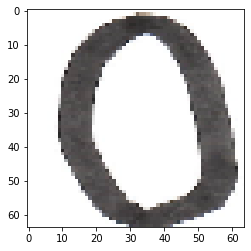

[[1. 0. 0.]]


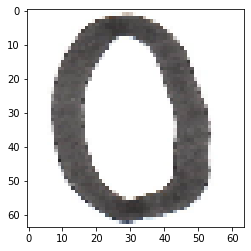

[[1. 0. 0.]]


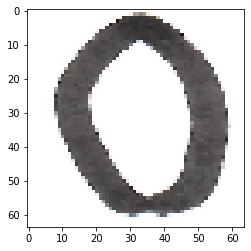

[[1. 0. 0.]]


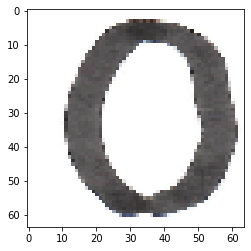

[[1. 0. 0.]]


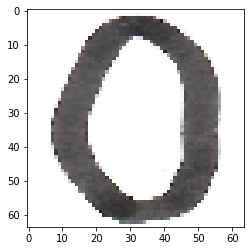

[[1. 0. 0.]]


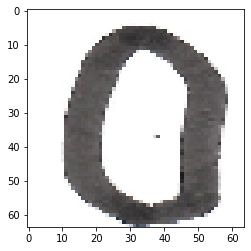

[[1. 0. 0.]]


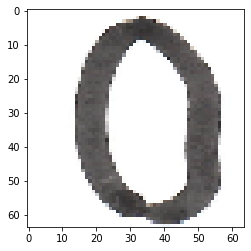

[[1. 0. 0.]]


KeyboardInterrupt: 

In [7]:
for i in range (0,150):
    test_batch_x, batch_y = test_set.next()
    image = test_batch_x[0]
    print(batch_y)
    plt.imshow(image)
    plt.show()


# Topologie des neuronalen Netzes

In [9]:
cnn_model = Sequential()

cnn_model.add(Conv2D(
    32, (3, 3), input_shape=(64, 64, 3), activation='relu',kernel_initializer='uniform', padding='same'))

cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(
    32, (3, 3), activation='relu',kernel_initializer='uniform', padding='same'))

cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())

cnn_model.add(Dense(56, activation='relu', kernel_initializer='uniform'))

cnn_model.add(Dense(3, activation='softmax', kernel_initializer='uniform'))

2021-10-14 10:46:13.907263: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [11]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Anzahl der Gradientenabstiege

In [12]:
epochs = 10

# Training

In [13]:
train_set.reset()
test_set.reset()
history = cnn_model.fit_generator(train_set, steps_per_epoch=steps_per_epoch, validation_data=test_set,
                                      validation_steps=validation_steps, epochs=epochs)

/Users/johannesriesterer/opt/anaconda3/envs/sciki/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-14 10:46:40.644942: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
300/300 [==============================] - 3s 8ms/step - loss: 1.1048 - accuracy: 0.4233 - val_loss: 1.0031 - val_accuracy: 0.7333
Epoch 2/10
300/300 [==============================] - 2s 7ms/step - loss: 0.4825 - accuracy: 0.7833 - val_loss: 0.1464 - val_accuracy: 0.9467
Epoch 3/10
300/300 [==============================] - 2s 7ms/step - loss: 0.1640 - accuracy: 0.9400 - val_loss: 0.1546 - val_accuracy: 0.9600
Epoch 4/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0795 - accuracy: 0.9700 - val_loss: 0.0701 - val_accuracy: 0.9800
Epoch 5/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0654 - accuracy: 0.9800 - val_loss: 0.0730 - val_accuracy: 0.9733
Epoch 6/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0288 - accuracy: 0.9900 - val_loss: 0.0996 - val_accuracy: 0.9600
Epoch 7/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0607 - accuracy: 0.9800 - val_loss: 0.1452 - val_accuracy: 0.9467
Epoch 

# Genauigkeit auf Train und Test Datensatz

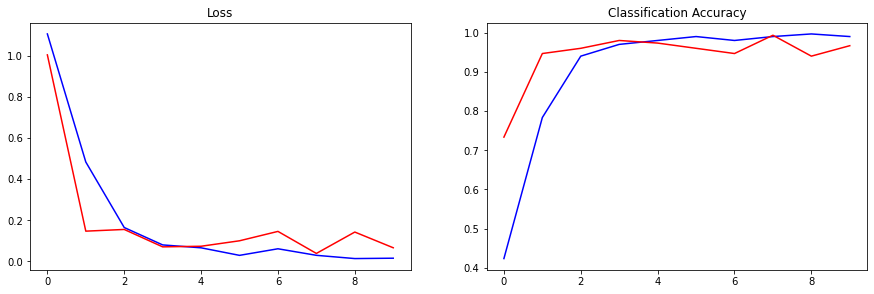

In [14]:
# plot loss
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.title('Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='test')

# plot accuracy
plt.subplot(222)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='test')
#plt.grid()
plt.show()

In [15]:
_, acc = cnn_model.evaluate_generator(train_set, steps=len(train_set), verbose=3)
print('Accuracy on Training Data:  %.3f' % (acc * 100.0))
_, acc = cnn_model.evaluate_generator(test_set, steps=len(test_set), verbose=3)
print('Accuracy on Test Data :  %.3f' % (acc * 100.0))

/Users/johannesriesterer/opt/anaconda3/envs/sciki/lib/python3.8/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Accuracy on Training Data:  100.000
Accuracy on Test Data :  96.667


In [16]:
pred=cnn_model.predict_generator(test_set, 150, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_set.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)


 20/150 [===>..........................] - ETA: 0s 

/Users/johannesriesterer/opt/anaconda3/envs/sciki/lib/python3.8/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


150/150 [==============================] - 1s 3ms/step


Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


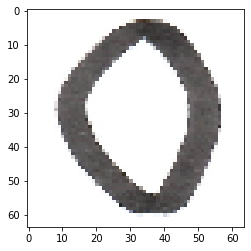

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


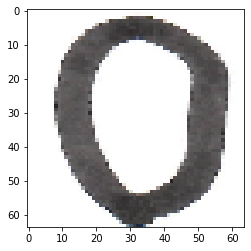

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


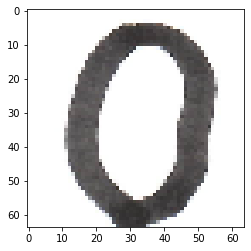

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


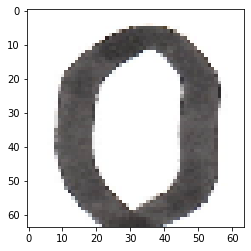

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


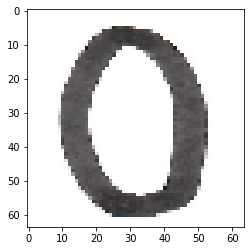

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


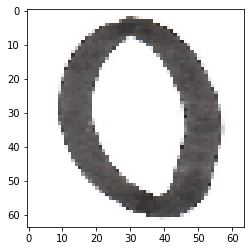

Label: [[1. 0. 0.]] duck | Vorhersage: [0.99 0.00 0.01] duck


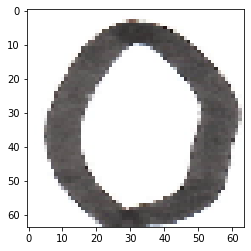

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


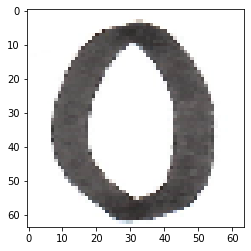

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


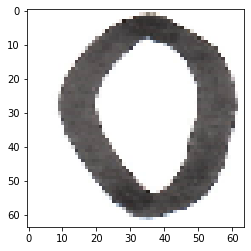

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


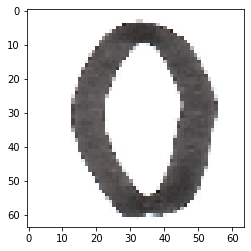

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


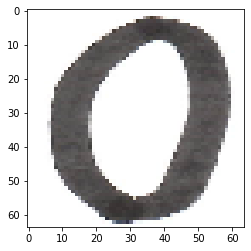

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


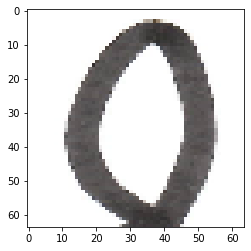

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


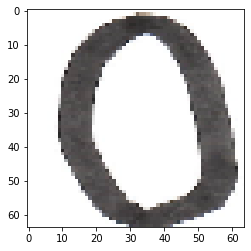

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


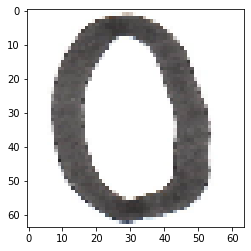

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


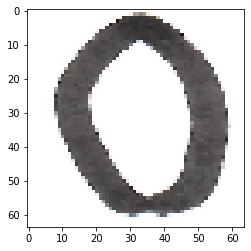

Label: [[1. 0. 0.]] duck | Vorhersage: [0.80 0.00 0.20] duck


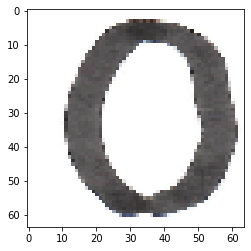

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


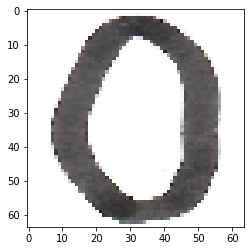

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


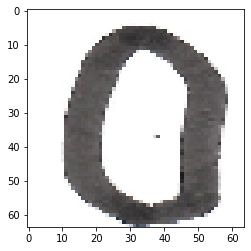

Label: [[1. 0. 0.]] duck | Vorhersage: [0.97 0.00 0.03] duck


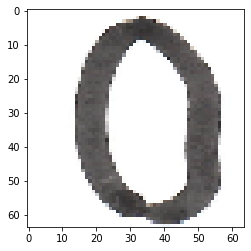

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


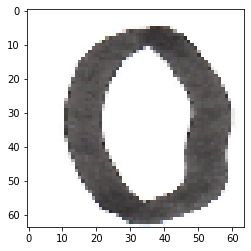

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


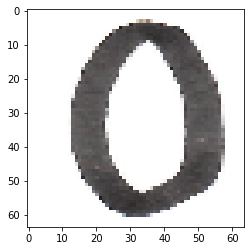

Label: [[1. 0. 0.]] duck | Vorhersage: [0.83 0.00 0.17] duck


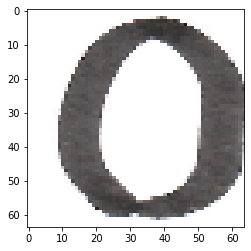

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


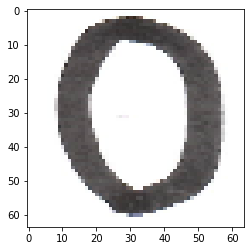

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


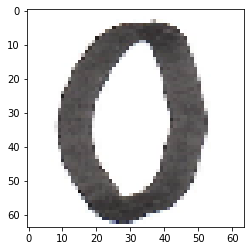

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


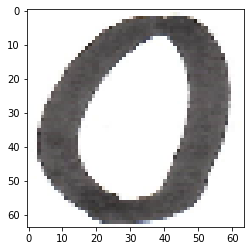

Label: [[1. 0. 0.]] duck | Vorhersage: [0.40 0.00 0.60] sparrow


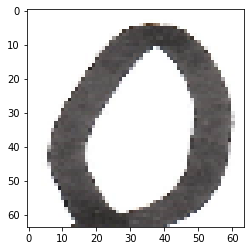

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


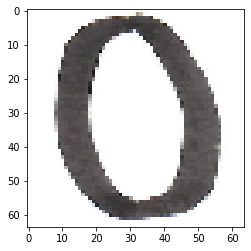

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


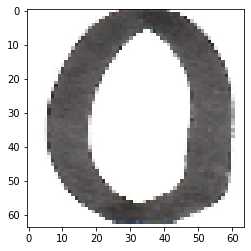

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


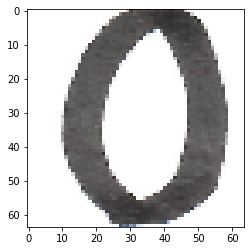

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


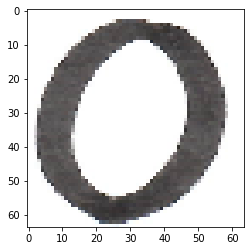

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


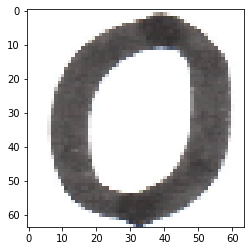

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


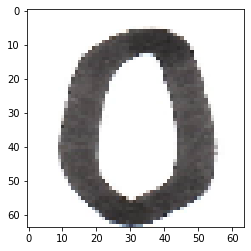

Label: [[1. 0. 0.]] duck | Vorhersage: [0.98 0.00 0.02] duck


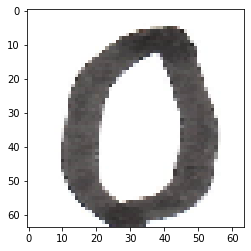

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


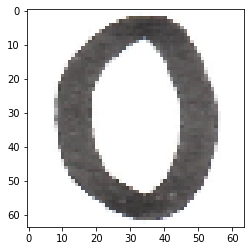

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


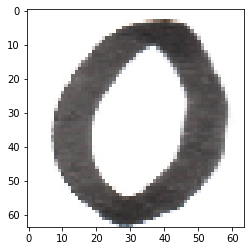

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


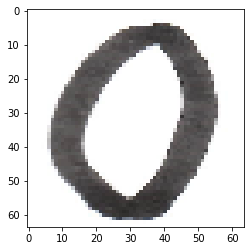

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


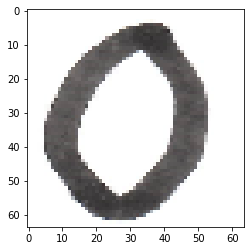

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


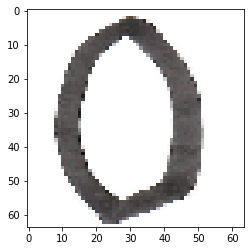

Label: [[1. 0. 0.]] duck | Vorhersage: [0.99 0.00 0.01] duck


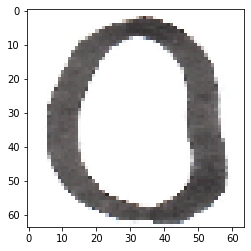

Label: [[1. 0. 0.]] duck | Vorhersage: [0.99 0.00 0.01] duck


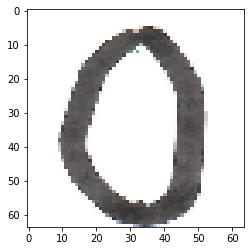

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


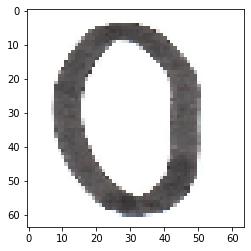

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


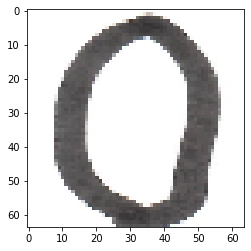

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


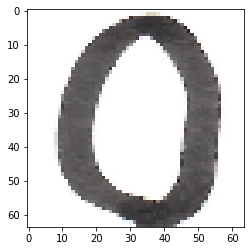

Label: [[1. 0. 0.]] duck | Vorhersage: [0.16 0.00 0.84] sparrow


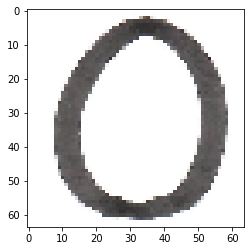

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


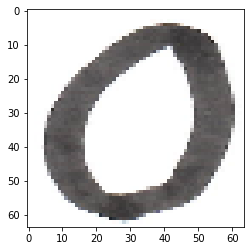

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


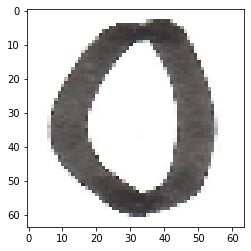

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


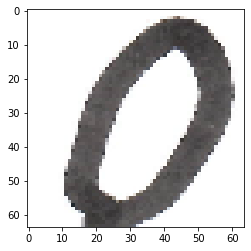

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


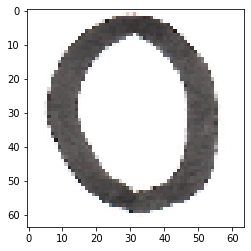

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


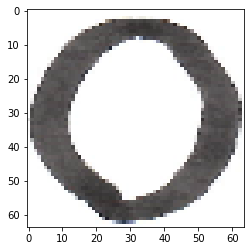

Label: [[1. 0. 0.]] duck | Vorhersage: [1.00 0.00 0.00] duck


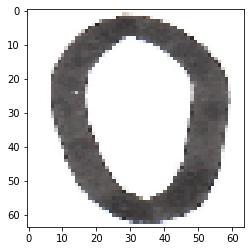

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


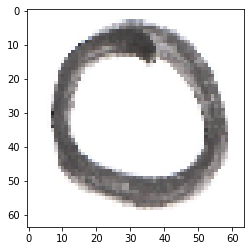

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


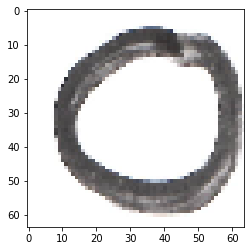

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


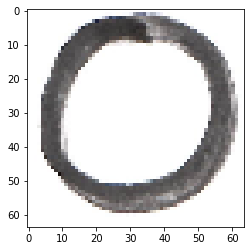

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.22 0.74 0.04] eagle


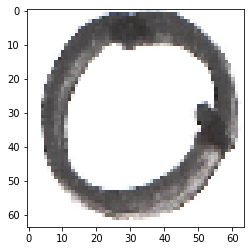

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


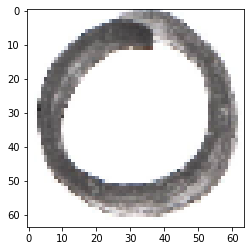

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


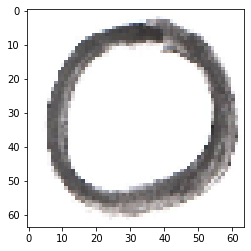

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


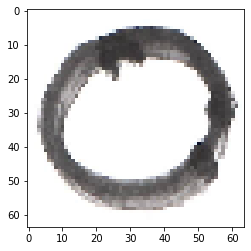

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


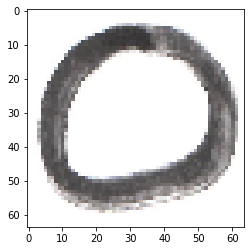

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


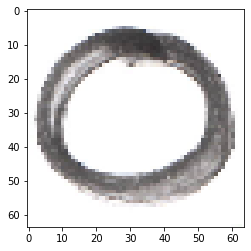

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


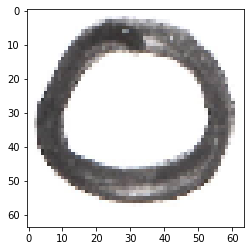

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


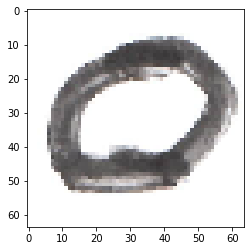

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


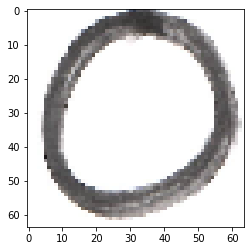

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


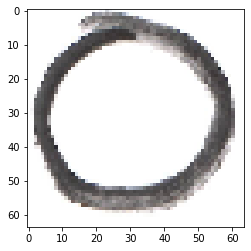

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.01 0.02 0.97] sparrow


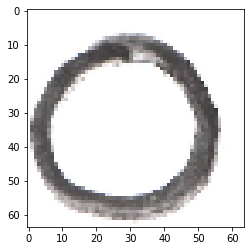

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.01 0.98 0.02] eagle


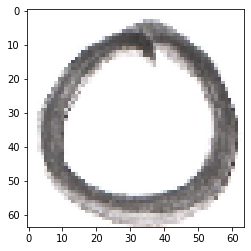

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


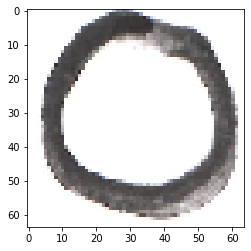

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


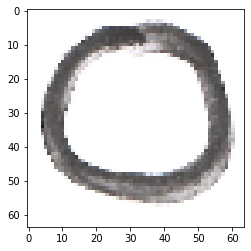

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


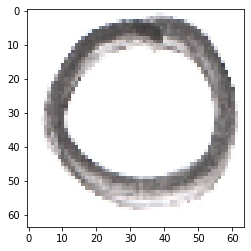

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


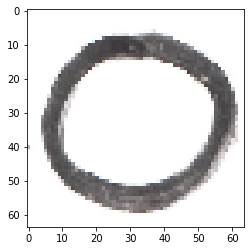

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


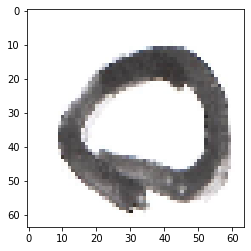

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


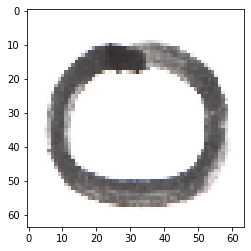

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


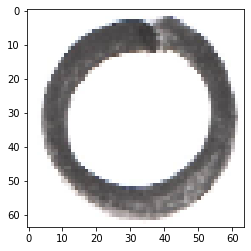

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


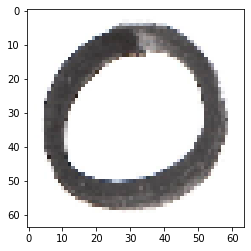

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


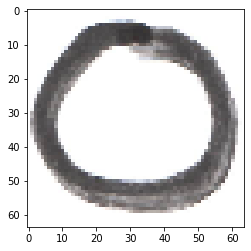

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


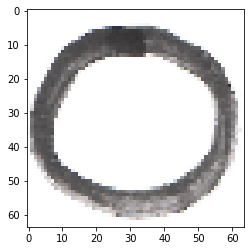

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


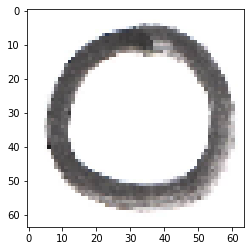

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


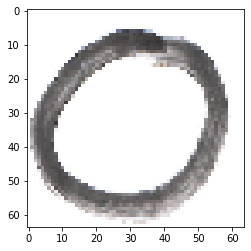

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


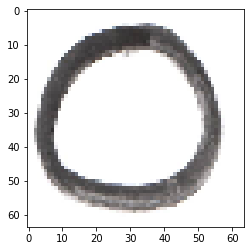

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


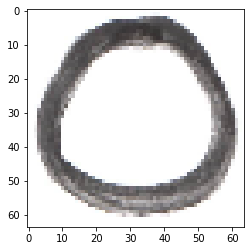

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


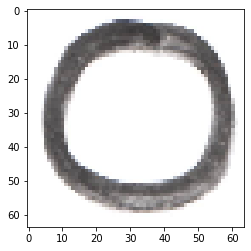

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


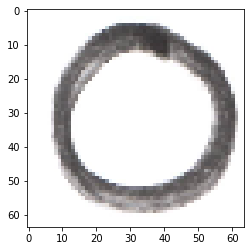

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


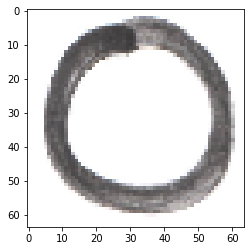

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


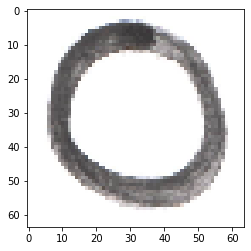

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


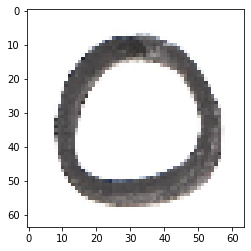

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


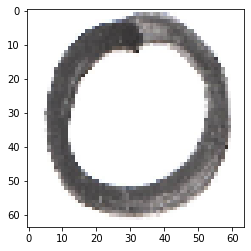

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


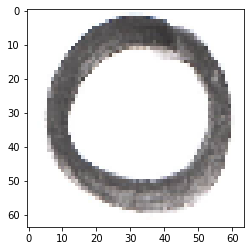

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


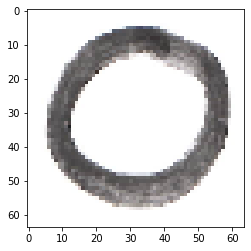

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.01 0.98 0.01] eagle


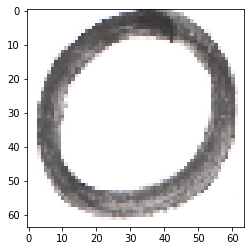

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


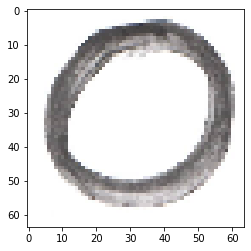

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


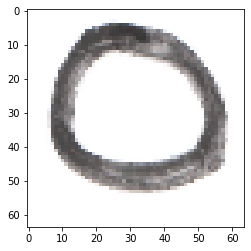

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


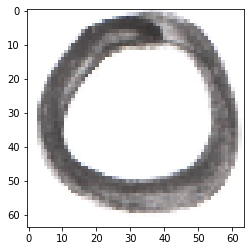

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


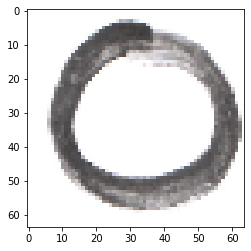

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.02 0.98 0.00] eagle


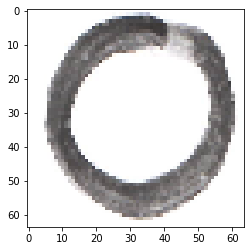

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


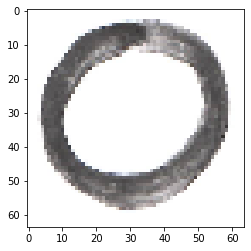

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


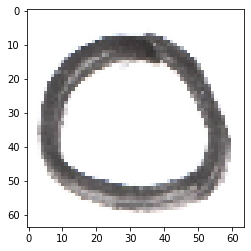

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


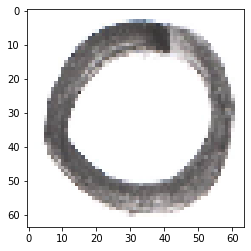

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


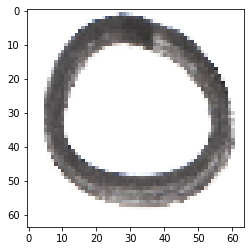

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


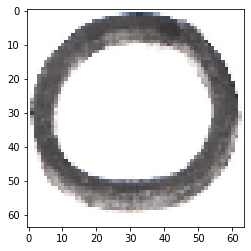

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


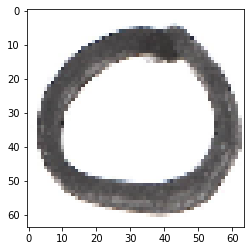

Label: [[0. 1. 0.]] eagle | Vorhersage: [0.00 1.00 0.00] eagle


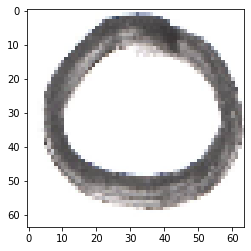

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


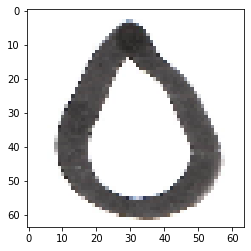

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.03 0.00 0.97] sparrow


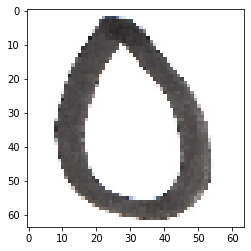

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


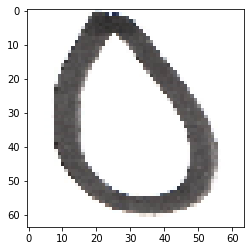

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


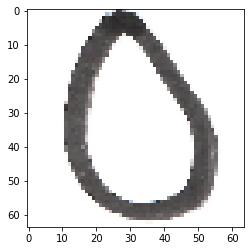

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


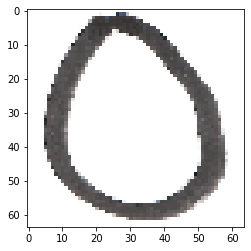

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


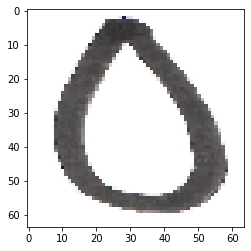

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


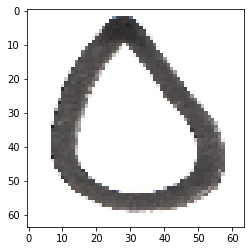

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.34 0.00 0.66] sparrow


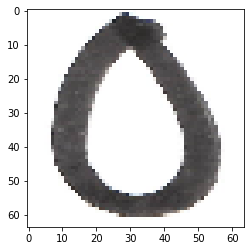

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


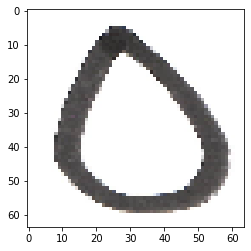

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


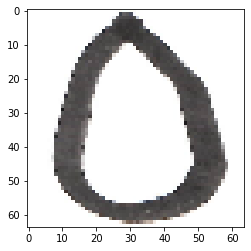

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


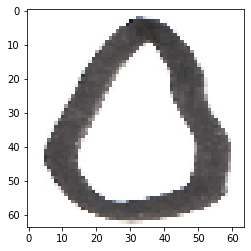

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


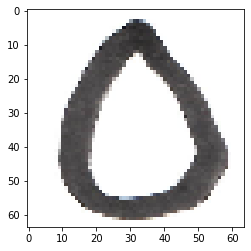

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


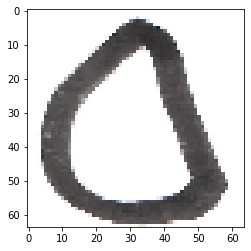

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


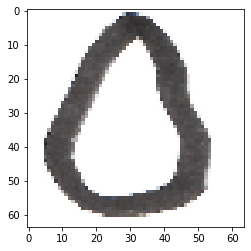

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


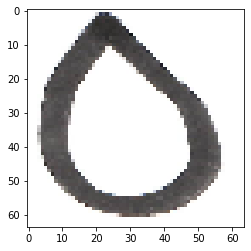

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


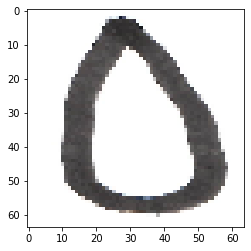

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


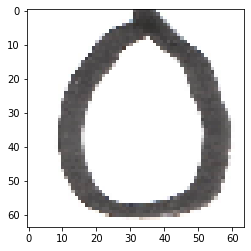

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


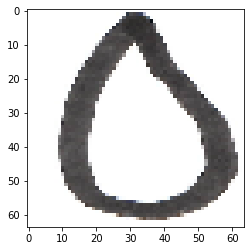

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


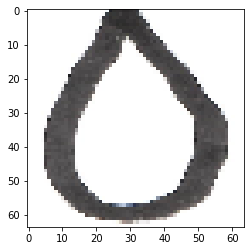

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


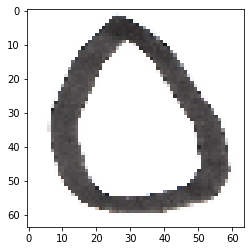

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


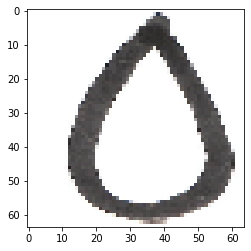

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


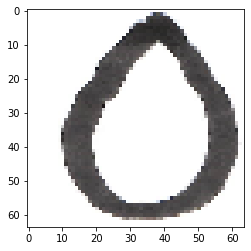

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


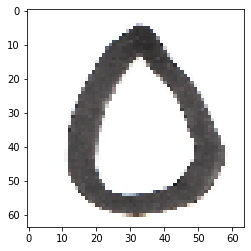

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


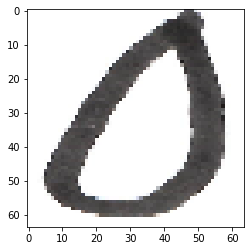

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.49 0.04 0.47] duck


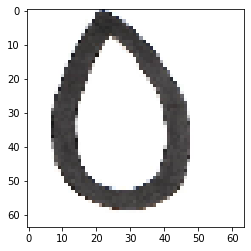

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


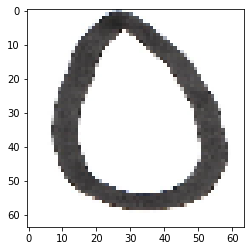

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


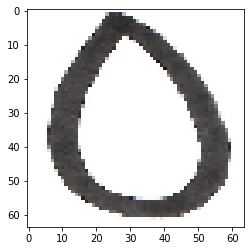

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


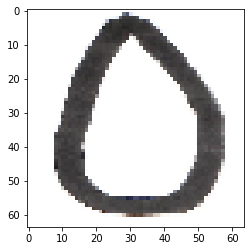

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


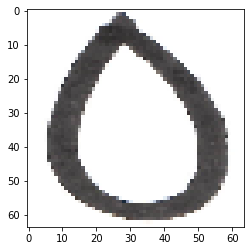

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


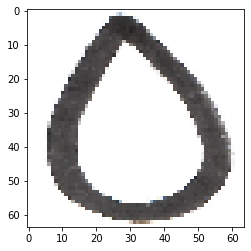

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


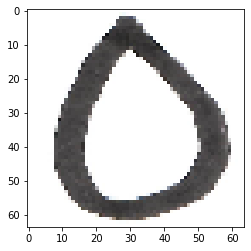

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


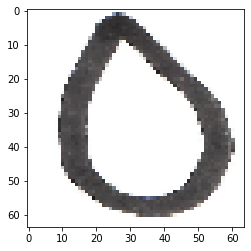

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


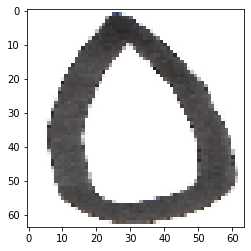

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


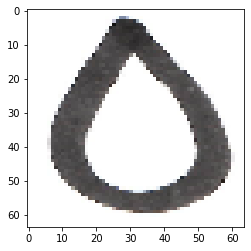

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


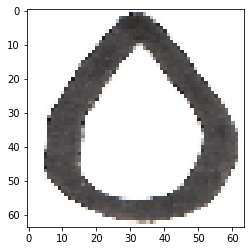

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


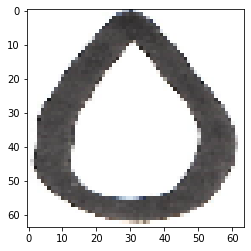

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


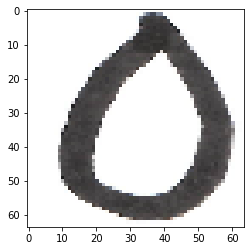

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.13 0.00 0.87] sparrow


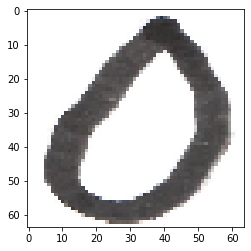

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


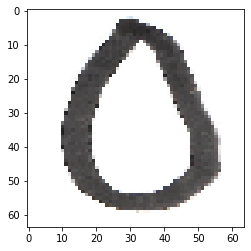

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


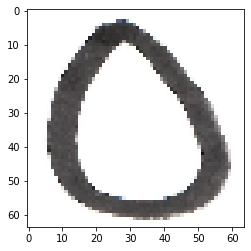

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.01 0.00 0.99] sparrow


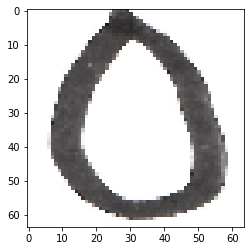

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


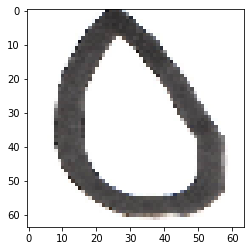

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


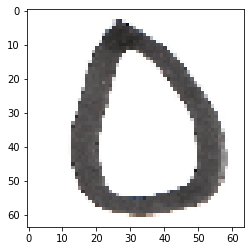

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


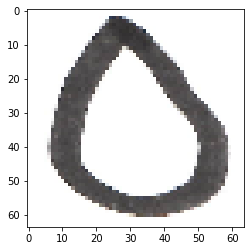

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


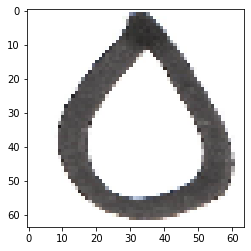

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


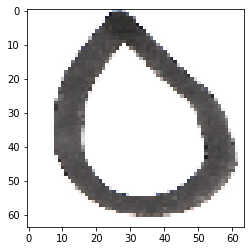

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.00 0.00 1.00] sparrow


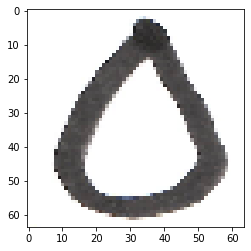

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.57 0.00 0.43] duck


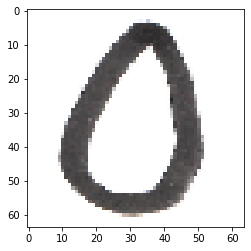

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.02 0.00 0.98] sparrow


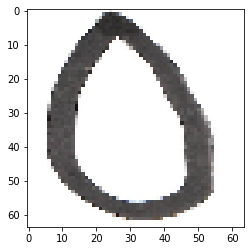

Label: [[0. 0. 1.]] sparrow | Vorhersage: [0.17 0.00 0.83] sparrow


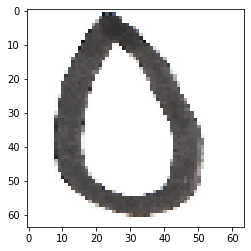

In [17]:
for i in range (0,150):
    test_batch_x, batch_y = test_set.next()
    image = test_batch_x[0]
    print("Label:", batch_y, labels[np.argmax(batch_y,axis=1)[0]], "|", "Vorhersage:", "[" + "%.2f" % pred[i][0] + " " + "%.2f" % pred[i][1] + " " + "%.2f" % pred[i][2] + "]"  , predictions[i])
    plt.imshow(image)
    plt.show()